In [1]:
pip list

Package                 Version
----------------------- -----------
adal                    1.2.7
adlfs                   2022.10.0
affine                  2.3.1
aiohttp                 3.8.3
aiosignal               1.3.1
altair                  4.2.0
anyio                   3.5.0
appdirs                 1.4.4
argon2-cffi             21.3.0
argon2-cffi-bindings    21.2.0
asciitree               0.3.3
asttokens               2.1.0
async-timeout           4.0.2
attrs                   22.1.0
azure-core              1.26.1
azure-datalake-store    0.0.52
azure-identity          1.12.0
azure-storage-blob      12.14.1
backcall                0.2.0
beautifulsoup4          4.11.1
bleach                  4.1.0
bokeh                   2.4.3
boltons                 21.0.0
Bottleneck              1.3.5
cachetools              5.2.0
carbonplan              0.5.0
carbonplan-data         0.4.0
carbonplan-styles       0.4.2
Cartopy                 0.18.0
certifi                 2022.9.24
cf-xarray    

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import cartopy.crs as ccrs
from carbonplan import styles  # noqa: F401
import intake

In [3]:
from cmip6_downscaling.analysis.analysis import (
    grab_big_city_data,
    load_big_cities,
)
from cmip6_downscaling.analysis.plot import plot_city_data

xr.set_options(keep_attrs=True)

In [4]:
cat = intake.open_esm_datastore(
    "https://cpdataeuwest.blob.core.windows.net/cp-cmip/version1/catalogs/global-downscaled-cmip6.json"
)

In [5]:
cat_subset = cat.search(method="GARD-SV")
cat_subset.df.head()
# cat_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,timescale,variable_id,method,downscaled_daily_data_uri,version
0,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cpdataeuwest.blob.core.windows.net/cp-...,v1
1,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cpdataeuwest.blob.core.windows.net/cp-...,v1
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,pr,GARD-SV,https://cpdataeuwest.blob.core.windows.net/cp-...,v1
3,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cpdataeuwest.blob.core.windows.net/cp-...,v1
4,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cpdataeuwest.blob.core.windows.net/cp-...,v1


In [6]:
cat_subset = cat.search(
    method="GARD-MV",
    source_id="MRI-ESM2-0",
    experiment_id="ssp245",
    variable_id="tasmax",
)

In [7]:
dsets = cat_subset.to_dataset_dict()
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.timescale.method'


{'ScenarioMIP.MRI.MRI-ESM2-0.ssp245.day.GARD-MV': <xarray.Dataset>
 Dimensions:    (lat: 721, lon: 1440, member_id: 1, time: 31046)
 Coordinates:
   * lat        (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
   * lon        (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
   * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31
   * member_id  (member_id) object 'r1i1p1f1'
 Data variables:
     tasmax     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 31046, 48, 48), meta=np.ndarray>
 Attributes: (12/30)
     Conventions:                                 CF-1.8
     activity_id:                                 ScenarioMIP
     cmip6_downscaling_contact:                   hello@carbonplan.org
     cmip6_downscaling_explainer:                 https://carbonplan.org/resea...
     cmip6_downscaling_institution:               CarbonPlan
     cmip6_downscaling_method:                    GARD-MV
     ...                        

In [8]:
ds = dsets["ScenarioMIP.MRI.MRI-ESM2-0.ssp245.day.GARD-MV"]
# ds.tasmax.sel(lat=89.25, lon=179.2, member_id='r1i1p1f1', time='2022-11-18',method='nearest').values

In [9]:
ds -= 273.15

In [10]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
projection = ccrs.PlateCarree()

In [11]:
east_africa_region = {"lat": slice(-3, 17), "lon": slice(17, 57)}
east_africa_tasmax = ds.tasmax.sel(time="2089-08-01").sel(**east_africa_region).load()
east_africa_tasmax = east_africa_tasmax.where(land.mask(east_africa_tasmax) != 0)

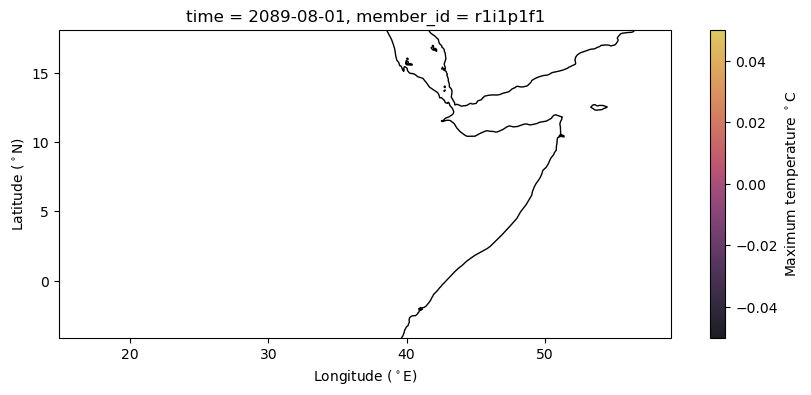

In [12]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(10, 4))
east_africa_tasmax.plot(
    cbar_kwargs=dict(label=r"Maximum temperature $^\circ$C"),
    cmap="warm_dark",
)
ax.coastlines()
ax.set_xticks([20, 30, 40, 50], crs=projection)
ax.set_xlabel(r"Longitude ($^\circ$E)")
ax.set_yticks([0, 5, 10, 15], crs=projection)
ax.set_ylabel(r"Latitude ($^\circ$N)")
plt.show()

In [13]:
time_slices = {"2030s": slice("2020", "2049"), "2080s": slice("2070", "2099")}

In [14]:
# Calculate the 30-year mean bracketing the 2080s.
tasmax_2080s = ds.tasmax.sel(time=time_slices["2080s"]).mean(dim="time").load()
# mask as above
tasmax_2080s = tasmax_2080s.where(land.mask(tasmax_2080s) == 0).load()

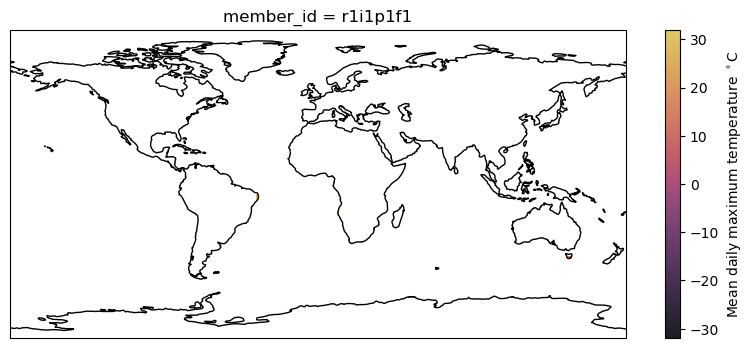

In [15]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(10, 4))
tasmax_2080s.plot(
    cbar_kwargs=dict(label=r"Mean daily maximum temperature $^\circ$C"),
    cmap="warm_dark",
)
ax.coastlines()
plt.show()

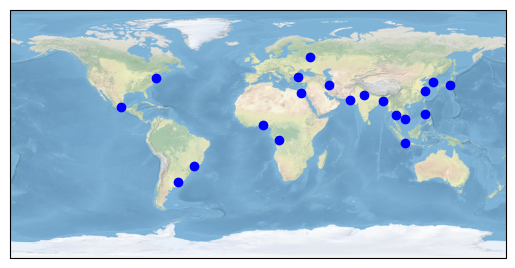

In [16]:
big_cities = load_big_cities(num_cities=20, add_additional_cities=False, plot=True)

In [17]:
[downscaled_cities] = grab_big_city_data([ds], big_cities)

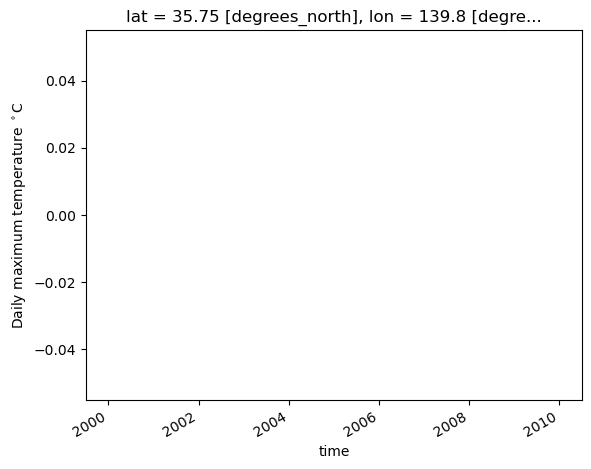

In [18]:
ts = downscaled_cities.sel(cities="Tokyo").tasmax
ts.plot()
plt.ylabel(r"Daily maximum temperature $^\circ$C")
plt.show()

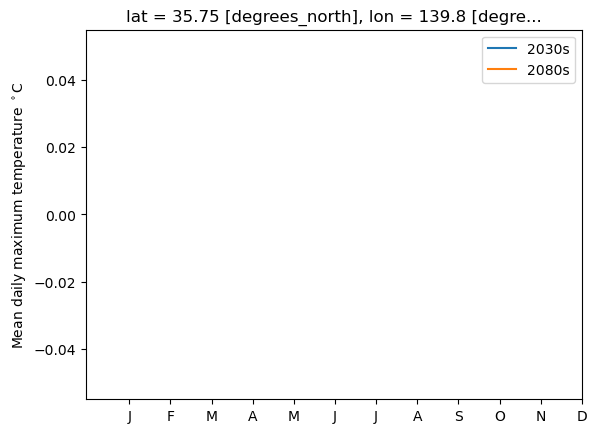

In [19]:
fig, ax = plt.subplots()
for label, time_slice in time_slices.items():
    ts.sel(time=time_slice).groupby("time.month").mean().plot(label=label)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])
plt.legend()
plt.ylabel(r"Mean daily maximum temperature $^\circ$C")
plt.xlabel("")
plt.show()

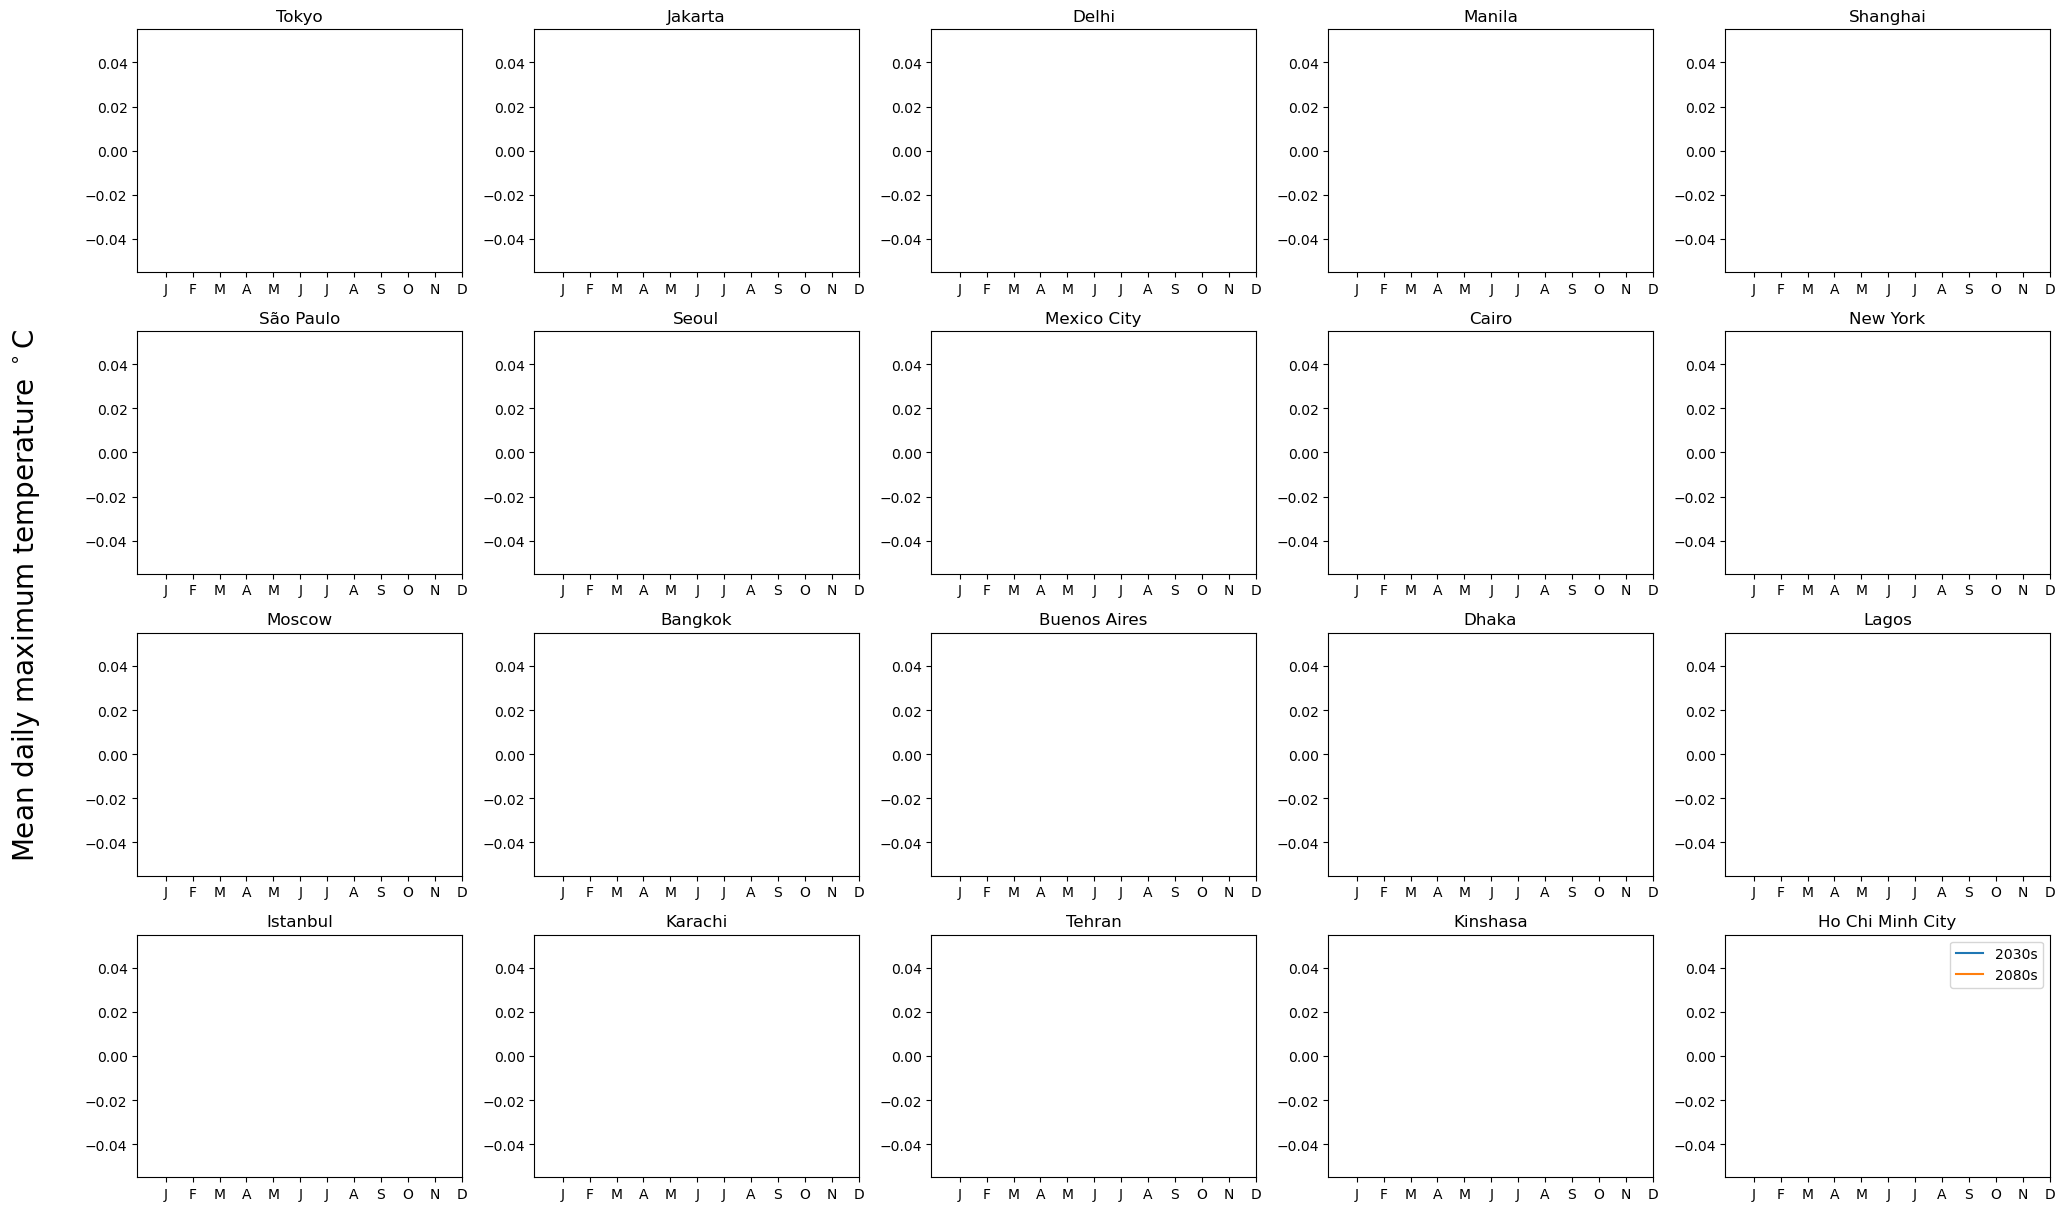

In [20]:
plot_city_data(
    downscaled_cities.tasmax,
    time_slices=time_slices,
    aggregation="seasonal_cycle",
    ylabel=r"Mean daily maximum temperature $^\circ$C",
)


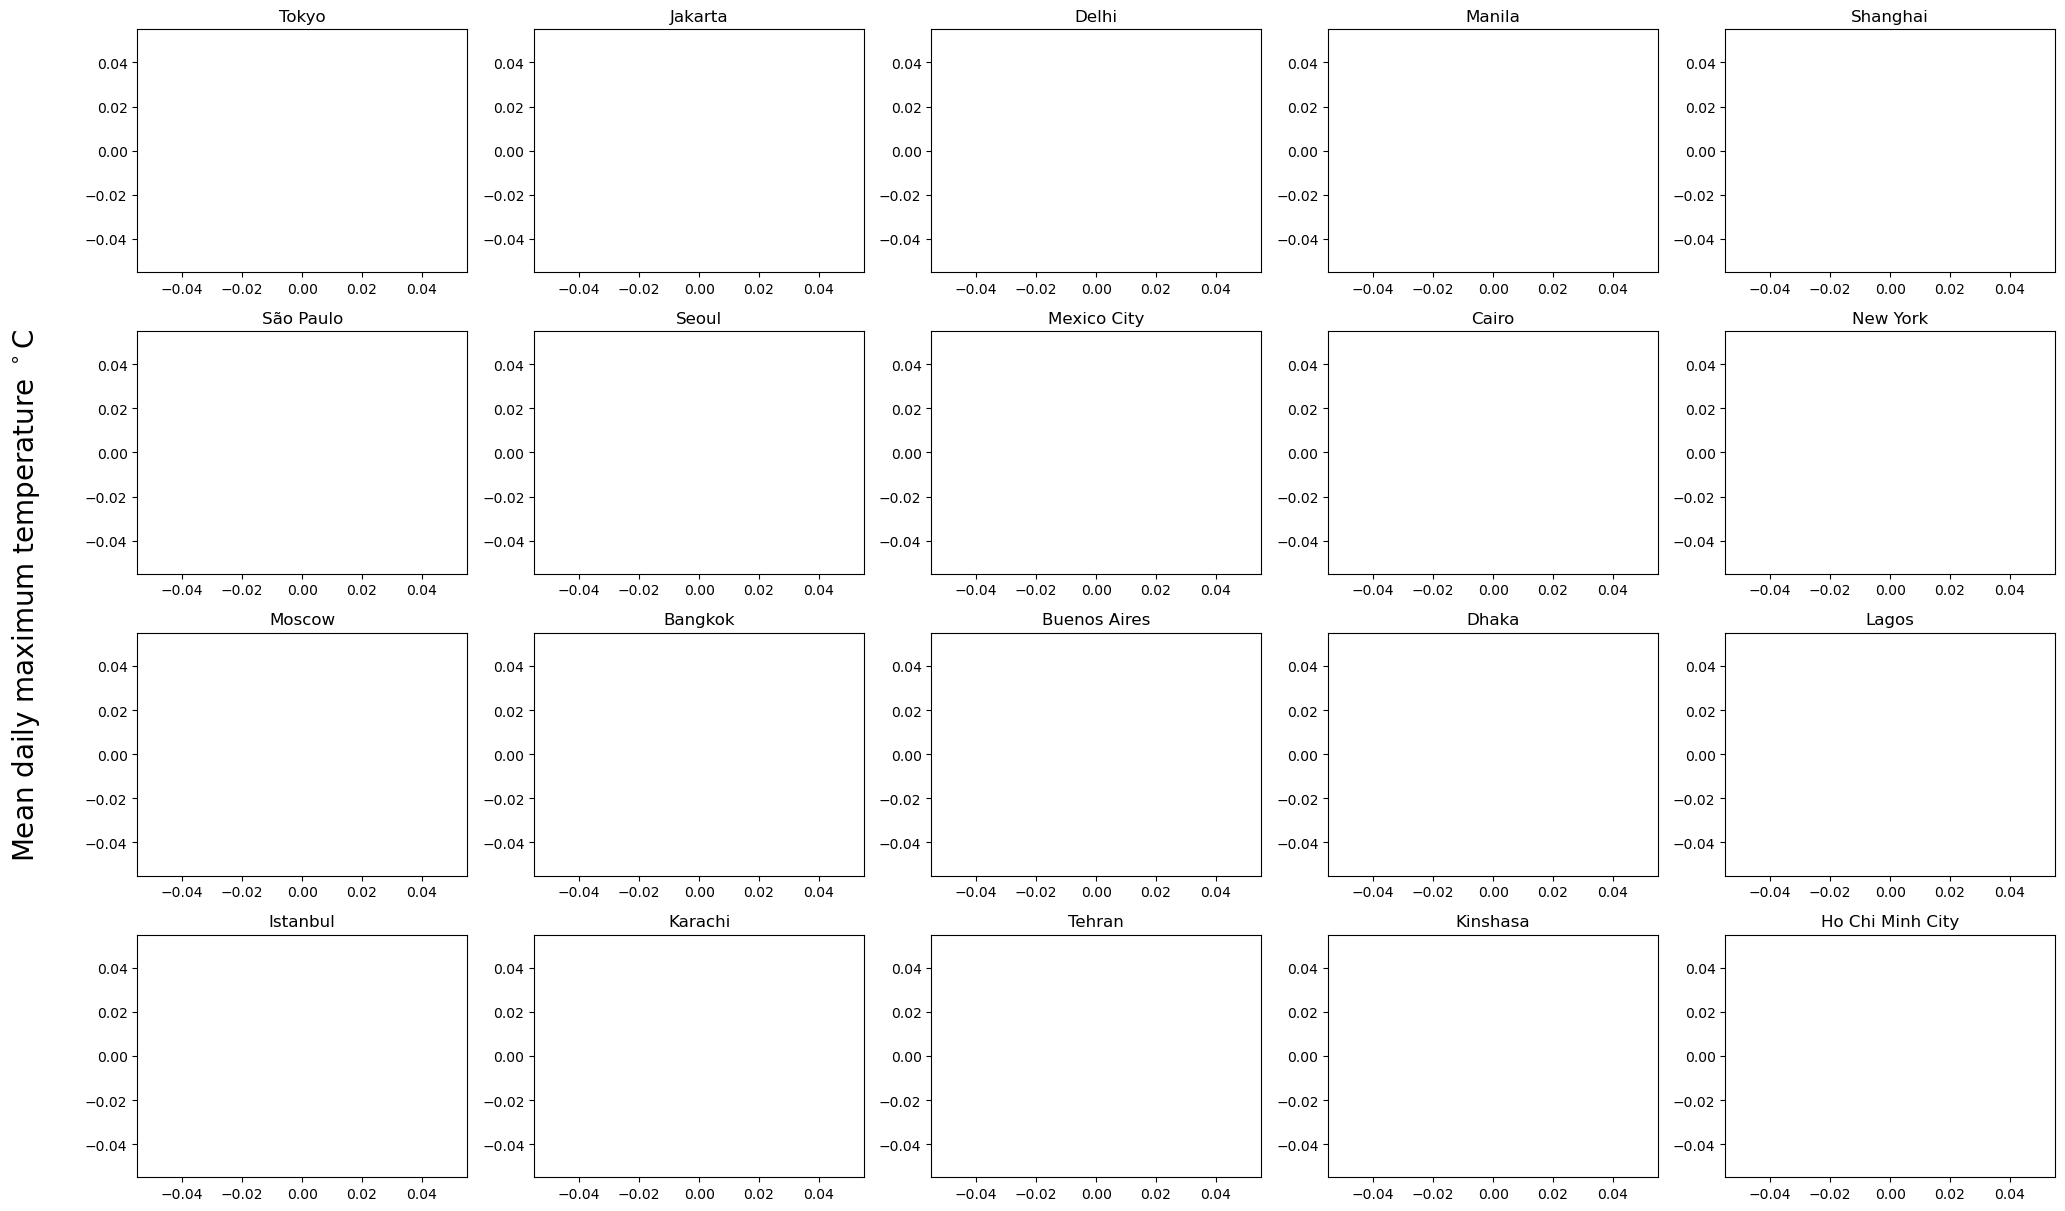

In [21]:

plot_city_data(
    downscaled_cities.tasmax,
    aggregation="annual",
    ylabel=r"Mean daily maximum temperature $^\circ$C",
)

In [22]:
# ts.to_dataframe().reset_index().drop(columns=["member_id", "cities", "lat", "lon"]).set_index(
#     "time"
# ).to_csv(r"")

In [23]:
# print("Dataset is {} GB".format(ds.sel(**east_africa_region).nbytes * 1e-9))

In [24]:
# save_subset = False
# if save_subset:
#     ds.sel(**east_africa_region).to_netcdf("region.nc")